In [89]:
import numpy as np
import os
import rasterio
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from skimage.morphology import binary_opening, binary_closing, disk
from sklearn.cluster import KMeans
from rasterio.warp import reproject, Resampling
from sklearn.metrics import confusion_matrix, f1_score
import scipy.ndimage as ndimage
from matplotlib.colors import ListedColormap

In [91]:
# Function to resample bands to a common resolution (10m)
def resample_band(src, target_shape):
    data = src.read(1)  # Read single-band image
    resampled = np.empty(target_shape, dtype=np.float32)  # Empty array to store resampled data
    
    # Perform resampling
    reproject(
        source=data,
        destination=resampled,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=src.transform,
        dst_crs=src.crs,
        resampling=Resampling.bilinear  # Bilinear interpolation for smooth resampling
    )
    return resampled

In [93]:
def load_multiband_image(folder_path):
    band_files = sorted([f for f in os.listdir(folder_path) if f.endswith(".tif")])  # Sort ensures correct band order
    bands = []
    target_shape = None
    # First, find the target shape using a high-resolution band (e.g., Band 2)
    with rasterio.open(os.path.join(folder_path, band_files[1])) as src:  # Band 2 (10m resolution)
        target_shape = src.read(1).shape  # Get height and width
    
    # Load and resample all bands
    for band_file in band_files:
        band_path = os.path.join(folder_path, band_file)
        with rasterio.open(band_path) as src:
            if src.read(1).shape != target_shape:
                band_data = resample_band(src, target_shape)  # Resample if needed
            else:
                band_data = src.read(1)  # Use original if already correct
            bands.append(band_data)
    image = np.stack(bands, axis=0)  # Stack bands to create (13, H, W) array
    print(f"Loaded image from {folder_path} with shape: {image.shape}")
    return image


In [95]:
def compute_ndvi(nir, red):
    return (nir - red) / (nir + red + 1e-10)  # Avoid division by zero
# Compute NDBI (Normalized Difference Built-up Index)
def compute_ndbi(swir, nir):
    return (swir - nir) / (swir + nir + 1e-10)
# Compute NDWI (Normalized Difference Water Index)
def compute_ndwi(green, nir):
    return (green - nir) / (green + nir + 1e-10)
# Compute SAVI (Soil Adjusted Vegetation Index)
def compute_savi(nir, red, L=0.5):
    return ((nir - red) / (nir + red + L + 1e-10)) * (1 + L)
# Compute BSI (Bare Soil Index) - useful for urban areas and deforestation
# Fixed version with swir as parameter
def compute_bsi(red, green, blue, nir, swir):
    return ((red + swir) - (nir + blue)) / ((red + swir) + (nir + blue) + 1e-10)
# Compute EVI (Enhanced Vegetation Index) - better for dense vegetation areas
def compute_evi(nir, red, blue, G=2.5, C1=6, C2=7.5, L=1):
    return G * ((nir - red) / (nir + C1 * red - C2 * blue + L + 1e-10))
# Compute MNDWI (Modified Normalized Difference Water Index)
def compute_mndwi(green, swir):
    return (green - swir) / (green + swir + 1e-10)
# --- Cloud masking ---
def create_cloud_mask(image, threshold=0.2):
    # For Sentinel-2, a simple approach uses band 1 (aerosols) and band 10 (cirrus)
    # High values in these bands often indicate cloud presence
    if image.shape[0] >= 11:  # Make sure we have enough bands
        cloud_indicator = 0.5 * image[0] + 0.5 * image[9]  # Band 1 + Band 10
        cloud_mask = cloud_indicator > threshold
        return cloud_mask
    else:
        # If bands are not available, return an empty mask
        return np.zeros((image.shape[1], image.shape[2]), dtype=bool)

In [97]:
def classify_land_cover(image):
    """
    Classify land cover into: Forest, Urban, Water, Bare Soil, Other
    Returns a classified map with values:
    0: Background/No Data
    1: Forest/Vegetation
    2: Urban/Built-up
    3: Water
    4: Bare Soil
    5: Other/Mixed
    """
    # Sentinel-2 band indices (0-based)
    # Band 2 = Blue, Band 3 = Green, Band 4 = Red, Band 8 = NIR, Band 11 = SWIR
    blue, green, red, nir, swir = image[1], image[2], image[3], image[7], image[10]
    
    # Compute indices
    ndvi = compute_ndvi(nir, red)
    ndbi = compute_ndbi(swir, nir)
    ndwi = compute_ndwi(green, nir)
    bsi = compute_bsi(red, green, blue, nir, swir)  # Fixed: added swir parameter
    
    # Create empty classification map
    land_cover = np.zeros((image.shape[1], image.shape[2]), dtype=np.uint8)
    
    # Define thresholds for classification (these should be calibrated based on your specific data)
    # Forest/Vegetation (high NDVI)
    land_cover[(ndvi > 0.4)] = 1
    
    # Urban/Built-up (high NDBI, low NDVI)
    land_cover[(ndbi > 0.1) & (ndvi < 0.2)] = 2
    
    # Water (high NDWI)
    land_cover[(ndwi > 0.3)] = 3
    
    # Bare Soil (high BSI, moderate-low NDVI)
    land_cover[(bsi > 0.0) & (ndvi < 0.3) & (ndvi > -0.1)] = 4
    
    # Areas not classified above will remain 0 or can be set to "Other/Mixed"
    land_cover[(land_cover == 0)] = 5
    
    # Apply morphological operations to reduce noise
    selem = disk(2)
    for class_id in range(1, 6):
        mask = land_cover == class_id
        mask = binary_closing(mask, selem)
        land_cover[mask] = class_id
    
    return land_cover

In [99]:
def detect_landcover_changes(image1, image2):
    # Classify both images
    lc1 = classify_land_cover(image1)
    lc2 = classify_land_cover(image2)
    
    # Create cloud masks and apply them
    cloud_mask1 = create_cloud_mask(image1)
    cloud_mask2 = create_cloud_mask(image2)
    combined_cloud_mask = cloud_mask1 | cloud_mask2
    
    # Create change map
    change_map = np.zeros_like(lc1, dtype=np.uint8)
    
    # Specifically detect deforestation (Forest -> Non-Forest)
    deforestation_mask = (lc1 == 1) & (lc2 != 1)
    
    # Specifically detect urbanization (Non-Urban -> Urban)
    urbanization_mask = (lc1 != 2) & (lc2 == 2)
    
    # Mask out clouds
    deforestation_mask[combined_cloud_mask] = False
    urbanization_mask[combined_cloud_mask] = False
    
    # Create a multi-class change map
    # 0: No change
    # 1: Deforestation
    # 2: Urbanization
    # 3: Other change
    
    # Start with general changes
    change_map[lc1 != lc2] = 3  # Other changes
    
    # Override with specific changes
    change_map[deforestation_mask] = 1  # Deforestation
    change_map[urbanization_mask] = 2  # Urbanization
    
    # Apply morphological operations to reduce noise
    selem = disk(2)
    
    # Process each class separately
    for class_id in [1, 2, 3]:
        class_mask = change_map == class_id
        class_mask = binary_closing(class_mask, selem)
        class_mask = binary_opening(class_mask, selem)
        
        # Remove small objects
        labeled_array, num_features = ndimage.label(class_mask)
        component_sizes = np.bincount(labeled_array.ravel())
        small_size = 50  # Minimum size to keep
        too_small = component_sizes < small_size
        too_small_mask = too_small[labeled_array]
        class_mask[too_small_mask] = False
        
        # Update change map
        change_map[change_map == class_id] = 0  # Clear previous class
        change_map[class_mask] = class_id  # Set filtered class
    
    # Also generate standard general change map for comparison
    standard_change_map = (lc1 != lc2).astype(np.uint8)
    standard_change_map[combined_cloud_mask] = 0
    
    # Compute additional spectral indices for visual analysis
    # Sentinel-2 band indices (0-based)
    blue1, green1, red1, nir1, swir1 = image1[1], image1[2], image1[3], image1[7], image1[10]
    blue2, green2, red2, nir2, swir2 = image2[1], image2[2], image2[3], image2[7], image2[10]
    
    # Compute indices for both images
    ndvi1 = compute_ndvi(nir1, red1)
    ndvi2 = compute_ndvi(nir2, red2)
    
    ndbi1 = compute_ndbi(swir1, nir1)
    ndbi2 = compute_ndbi(swir2, nir2)
    
    # Compute absolute differences
    ndvi_diff = ndvi2 - ndvi1  # Negative values indicate vegetation loss
    ndbi_diff = ndbi2 - ndbi1  # Positive values indicate urban growth
    
    return change_map, standard_change_map, {
        'lc1': lc1,
        'lc2': lc2,
        'cloud_mask': combined_cloud_mask,
        'ndvi_diff': ndvi_diff,
        'ndbi_diff': ndbi_diff,
        'deforestation_mask': deforestation_mask,
        'urbanization_mask': urbanization_mask
    }

In [101]:
def plot_landcover_changes(image1, image2, change_map, additional_maps):
    # Create RGB composites for better visualization
    # For Sentinel-2: R=Band 4, G=Band 3, B=Band 2
    rgb1 = np.stack([image1[3], image1[2], image1[1]], axis=-1)
    rgb2 = np.stack([image2[3], image2[2], image2[1]], axis=-1)
  
    # Normalize for display
    def normalize(img):
        return np.clip((img - np.percentile(img, 2)) / (np.percentile(img, 98) - np.percentile(img, 2)), 0, 1)
    
    rgb1_norm = normalize(rgb1)
    rgb2_norm = normalize(rgb2)
    
    # Create binary change map (0 = no change, 1 = change)
    binary_change_map = (change_map > 0).astype(np.uint8)
    
    # Set up change map color map
    change_colors = ['black', 'white']
    binary_cmap = ListedColormap(change_colors)
    
    # Create plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot RGB images
    axes[0, 0].imshow(rgb1_norm)
    axes[0, 0].set_title("Before Image (RGB)")
    
    axes[0, 1].imshow(rgb2_norm)
    axes[0, 1].set_title("After Image (RGB)")
    
    # Plot NDVI difference
    im1 = axes[1, 0].imshow(additional_maps['ndvi_diff'], cmap='RdYlGn', vmin=-0.5, vmax=0.5)
    axes[1, 0].set_title("NDVI Difference (After - Before)")
    plt.colorbar(im1, ax=axes[1, 0], fraction=0.046, pad=0.04)
    
    # Plot binary change map
    im2 = axes[1, 1].imshow(binary_change_map, cmap=binary_cmap, vmin=0, vmax=1)
    axes[1, 1].set_title("Binary Change Map (0=No Change, 1=Change)")
    plt.colorbar(im2, ax=axes[1, 1], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.suptitle("Land Cover Change Analysis", fontsize=16, y=0.98)
    plt.show()
    
    # Save binary change map
    plt.figure(figsize=(10, 8))
    plt.imshow(binary_change_map, cmap=binary_cmap, vmin=0, vmax=1)
    plt.colorbar(label='Change')
    plt.title("Binary Change Map")
    plt.savefig('binary_change_map.png', dpi=300, bbox_inches='tight')
    
    # Keep deforestation map but remove urbanization
    plt.figure(figsize=(10, 8))
    plt.imshow(additional_maps['deforestation_mask'], cmap='Reds')
    plt.colorbar(label='Deforestation')
    plt.title("Deforestation Areas")
    plt.savefig('deforestation_map.png', dpi=300, bbox_inches='tight')

In [103]:

def quantify_changes(change_map, pixel_area=100):  # Default pixel area 100m² (10x10m)
    """
    Quantify the amount of each change type
    """
    # Count pixels of each class
    deforestation_pixels = np.sum(change_map == 1)
    urbanization_pixels = np.sum(change_map == 2)
    other_change_pixels = np.sum(change_map == 3)
    total_changed_pixels = deforestation_pixels + urbanization_pixels + other_change_pixels
    total_pixels = change_map.size
    
    # Convert to area
    deforestation_area = deforestation_pixels * pixel_area
    urbanization_area = urbanization_pixels * pixel_area
    other_change_area = other_change_pixels * pixel_area
    total_changed_area = total_changed_pixels * pixel_area
    total_area = total_pixels * pixel_area
    
    # Calculate percentages
    deforestation_pct = (deforestation_pixels / total_pixels) * 100
    urbanization_pct = (urbanization_pixels / total_pixels) * 100
    other_change_pct = (other_change_pixels / total_pixels) * 100
    total_change_pct = (total_changed_pixels / total_pixels) * 100
    
    # Prepare results
    results = {
        'deforestation_pixels': deforestation_pixels,
        'urbanization_pixels': urbanization_pixels,
        'other_change_pixels': other_change_pixels,
        'total_changed_pixels': total_changed_pixels,
        'total_pixels': total_pixels,
        'deforestation_area_m2': deforestation_area,
        'urbanization_area_m2': urbanization_area,
        'other_change_area_m2': other_change_area,
        'total_changed_area_m2': total_changed_area,
        'total_area_m2': total_area,
        'deforestation_pct': deforestation_pct,
        'urbanization_pct': urbanization_pct,
        'other_change_pct': other_change_pct,
        'total_change_pct': total_change_pct,
    }
    
    return results

Loaded image from imgs_1 with shape: (13, 858, 557)
Loaded image from imgs_2 with shape: (13, 858, 557)


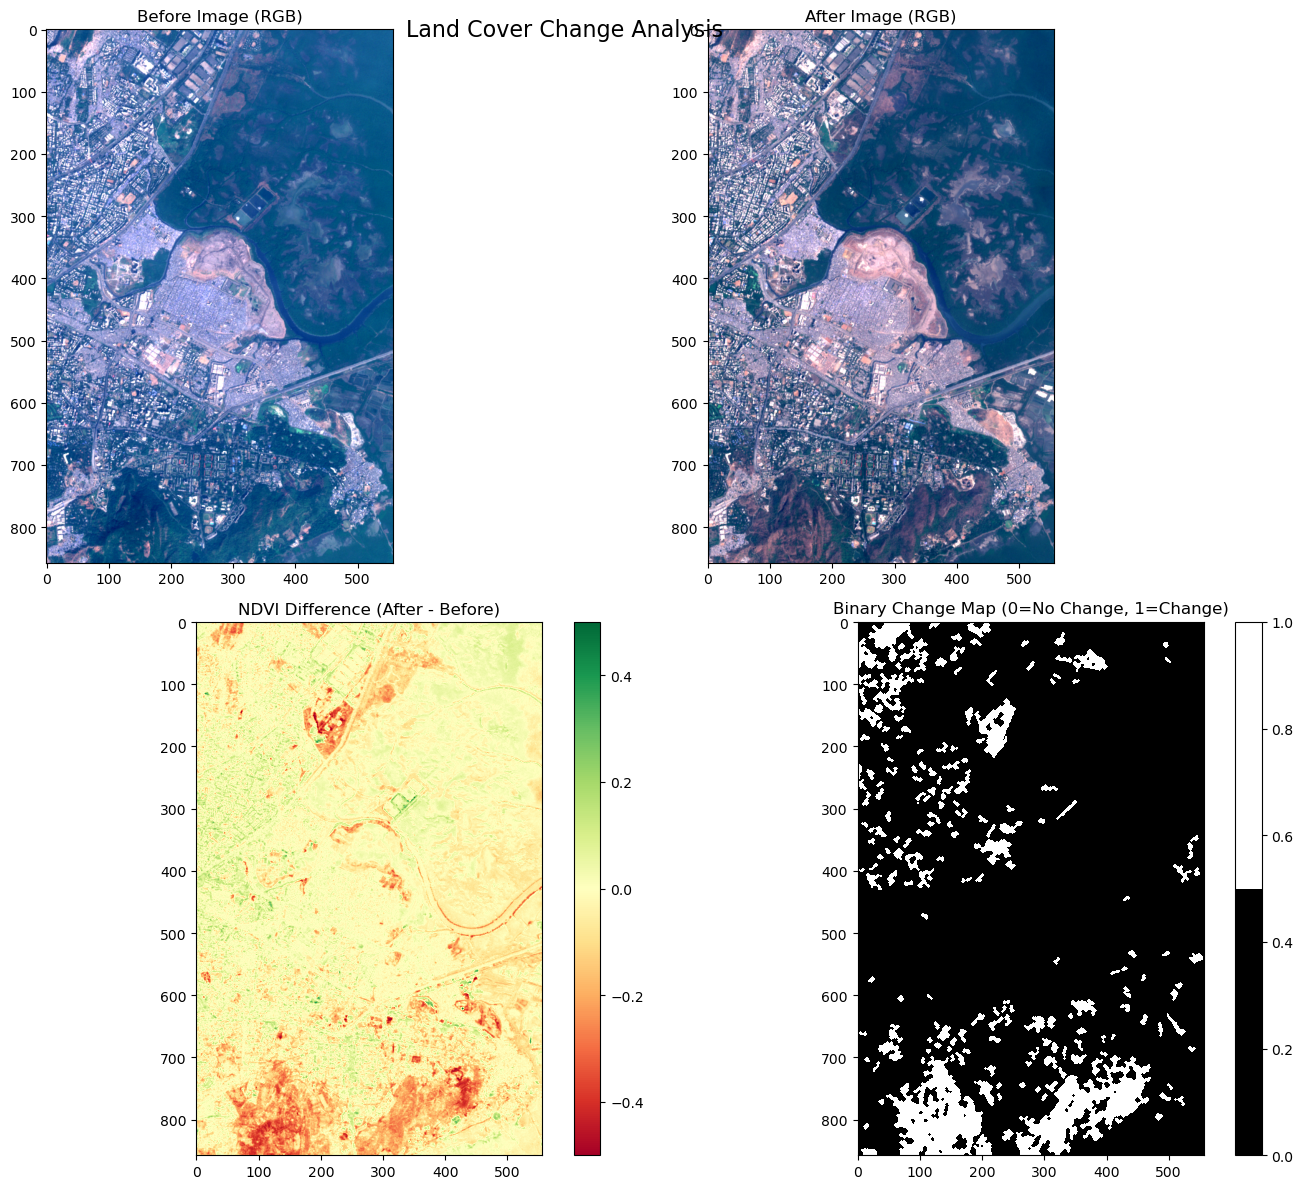


Land Cover Change Analysis Results:
Total area analyzed: 47.79 km²
Total changed area: 6.14 km² (12.85%)

Deforestation: 4.32 km² (9.03%)
Other changes: 1.82 km² (3.82%)


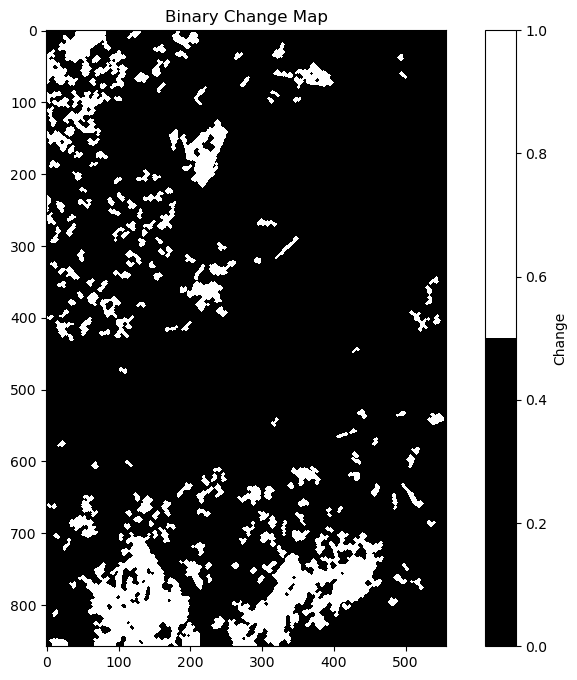

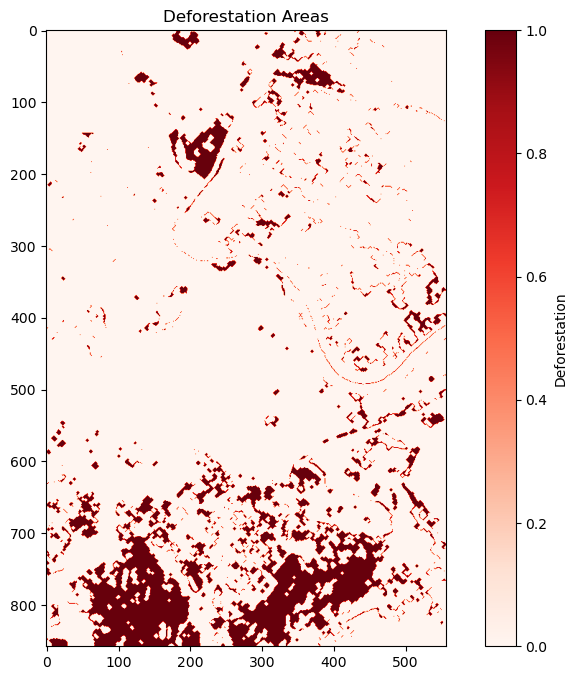

In [113]:

# --- Main execution function ---
def run_landcover_change_detection(before_folder, after_folder, ground_truth_path=None):
    # Load images
    image1 = load_multiband_image(before_folder)
    image2 = load_multiband_image(after_folder)
    
    # Ensure images have the expected number of bands
    if image1.shape[0] != 13 or image2.shape[0] != 13:
        print(f"Warning: Expected 13 bands, but got {image1.shape[0]} and {image2.shape[0]}. Proceeding anyway.")
    
    # Perform Change Detection with classification
    change_map, standard_change_map, additional_maps = detect_landcover_changes(image1, image2)
    
    # Plot the results with enhanced visualization
    plot_landcover_changes(image1, image2, change_map, additional_maps)
    
    # Quantify changes
    change_stats = quantify_changes(change_map)
    
    # Print results
    print("\nLand Cover Change Analysis Results:")
    print(f"Total area analyzed: {change_stats['total_area_m2']/1000000:.2f} km²")
    print(f"Total changed area: {change_stats['total_changed_area_m2']/1000000:.2f} km² ({change_stats['total_change_pct']:.2f}%)")
    print(f"\nDeforestation: {change_stats['deforestation_area_m2']/1000000:.2f} km² ({change_stats['deforestation_pct']:.2f}%)")
   
    print(f"Other changes: {change_stats['other_change_area_m2']/1000000:.2f} km² ({change_stats['other_change_pct']:.2f}%)")
    
    # Evaluate against ground truth if available
    if ground_truth_path:
        try:
            with rasterio.open(ground_truth_path) as src:
                ground_truth_map = src.read(1)
                
            # Calculate accuracy metrics using standard change map
            conf_matrix = confusion_matrix(ground_truth_map.flatten(), standard_change_map.flatten())
            f1 = f1_score(ground_truth_map.flatten(), standard_change_map.flatten())
            
            print("\nAccuracy Metrics (for general change detection):")
            print(f"F1 Score: {f1:.4f}")
            print("Confusion Matrix:")
            print(conf_matrix)
        except Exception as e:
            print(f"Error loading ground truth: {e}")
    
    return change_map, change_stats, additional_maps
# File paths (Update these with actual folder paths)
before_folder = "imgs_1"  # Folder containing before images
after_folder = "imgs_2"   # Folder containing after images
# Optional ground truth map path (if available)
ground_truth_path = None  # "ground_truth.tif"
# Run the complete enhanced pipeline
if __name__ == "__main__":
    change_map, change_stats, additional_maps = run_landcover_change_detection(before_folder, after_folder, ground_truth_path)